# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [14]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append('/home/listic/Downloads/Maritme_Mask_RCNN (copy)/mrcnn')  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import Maritime config
sys.path.append(os.path.join(ROOT_DIR, "/home/listic/Downloads/Maritme_Mask_RCNN (copy)/mrcnn"))  # To find local version
#from pycocotools.coco import COCO
import maritime

from matplotlib.pyplot import imshow
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_maritime_0006.h5")


# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "test_images/maritime")

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [15]:
class InferenceConfig(maritime.MaritimeConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               50
MEAN_PIXEL                     [152.54099612 151.549730

## Create Model and Load Trained Weights

In [16]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [17]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['undetected','porte','fenetre','lampe','prises','interrupteur','radiateur','baes']
colors= [[0,0,0],[0,255,0],[128,0,0],[0,0,255],[255,255,255],[0,255,255],[255,255,128],[128,255,255]]

## Run Object Detection

Processing 1 images
image                    shape: (3040, 6080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -152.54100  max:  103.95970  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 6080.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


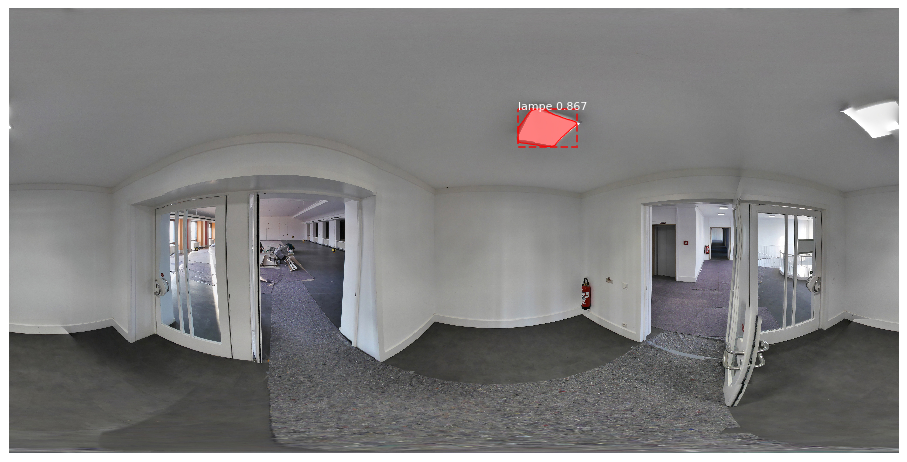

Processing 1 images
image                    shape: (3040, 6080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -152.54100  max:  103.95970  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 6080.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32

*** No instances in image 00045-pano.jpg to draw *** 

Processing 1 images
image                    shape: (3040, 6080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -152.54100  max:  103.95970  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 6080.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


In [20]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
#image = skimage.io.imread(os.path.join(IMAGE_DIR, 'Panorama_image.jpg'))

# Run detection
results = model.detect([image], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


for f in file_names:
    image = skimage.io.imread(os.path.join(IMAGE_DIR, f))

    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0] 
    visualize.save_image(image,f, r['rois'], r['masks'], r['class_ids'], r['scores'],class_names)


In [ ]:

def create_masked_image(image, masks, class_ids):

    # Generate random colors
    N = masks.shape[-1]
    
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    masked_image = image.astype(np.uint32).copy()

    for i in range(N):
        #Label
        class_id = class_ids[i]
        label = class_names[class_id]

        global colors
        color = colors[i]
        # Mask
        mask = masks[:, :, i]
        masked_image = visualize.apply_mask(masked_image, mask, color)

    return masked_image.astype(np.uint8)


# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
masked_image = create_masked_image(image, r['masks'], r['class_ids'])
imshow(masked_image.astype(np.uint8))